In [1]:
using Plots
using LinearAlgebra
using DelimitedFiles
using Distributions
using StatsBase
# using GLM
using ScikitLearn
gr()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


Plots.GRBackend()

In [2]:
# distributions
dnorm = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

# 例39 10-fold CV

In [3]:
function cv_linear(X, y, K)
    n = length(y)
    m = ceil(Int, n / K)
    S = 0.0
    # println("$n $m")
    for j in 1:K
        test = collect(1 + (j - 1) * m:1:j * m)
        train = collect([x for x in 1:n if !(x in test)])
        # println("$j $(length(test)) $(length(train))")
        
        β = inv(X[train, :]' * X[train, :]) * X[train, :]' * y[train]
        error = y[test] .- X[test, :] * β
        S += norm(error) ^ 2
    end
    S / n
end

cv_linear (generic function with 1 method)

In [4]:
K = 10
n = 100
p = 5
X = zeros(n, p + 1)
X[:, 1] = ones(n)
for i in 2:p+1
    X[:, i] .= rand(dnorm, n)
end
β = rand(dnorm, p + 1)
β[2:3] .= 0  # python [1, 2] -> julia [2, 3]
y = X * β .+ rand(dnorm, n);
cv_linear(X[:, [1, 4, 5, 6]], y, K)

0.8690392768696711

In [5]:

cv_linear(X, y, K)

0.9098196409642264

In [6]:
# 何度も繰り替えす
U = Float64[]
V = Float64[]

K = 10
n = 100
p = 5
X = zeros(n, p + 1)
X[:, 1] = ones(n)
for i in 2:p+1
    X[:, i] .= rand(dnorm, n)
end
β = rand(dnorm, p + 1)
β[2:3] .= 0  # python [1, 2] -> julia [2, 3]

for _ in 1:100
    y = X * β .+ rand(dnorm, n);
    u = cv_linear(X[:, [1, 4, 5, 6]], y, K)
    v = cv_linear(X, y, K)
    push!(U, u)
    push!(V, v)
end

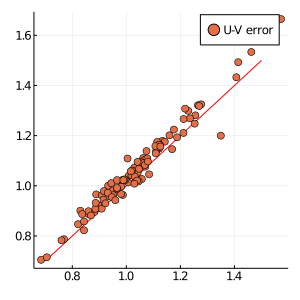

In [7]:
x_seq = collect(0.7:0.05:1.5);
y_seq = x_seq;

p = plot(size=(300, 300));
plot!(p, x_seq, y_seq, color=:red, label="")
scatter!(U, V, label="U-V error")
p

# 例40 Kはいくつが良いか

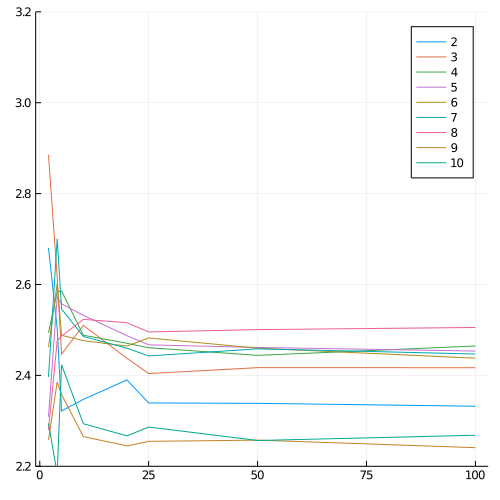

In [8]:
n = 100
p = 5

pp = plot(size=(500, 500), ylims=(2.2, 3.2))

for j in 2:1:10
    X = zeros(n, p + 1)
    X[:, 1] = ones(n)
    for i in 2:p+1
        X[:, i] .= rand(dnorm, n)
    end
    β = rand(dnorm, p + 1)
    β[2:3] .= 0  # python [1, 2] -> julia [2, 3]

    U = Float64[]
    V = Float64[]
    for k in 2:1:n
        if n % k == 0
            push!(U, k)
            push!(V, cv_linear(X, y, k))
        end
    end
    
    plot!(pp, U, V, label="$j")
end

pp

# 例41

- IRISのknnでCV (略)

# 例42 高速なCVと時間比較

In [9]:
function cv_fast(X, y, K)
    n = length(y)
    m = ceil(Int, n / K)
    H = X * inv(X' * X) * X'
    I = diagm(repeat([1], n))
    e = (I .- H) .* y
    I = diagm(repeat([1], m))
    S = 0
    for j in 1:K
        test = collect(1 + (j - 1) * m:1:j * m)
        mat1 = inv(I .- H[test, test]) * e[test]
        S += mat1' * mat1
    end
    S / n
end

cv_fast (generic function with 1 method)

In [10]:
v1 = cv_fast(X, y, 10)
v2 = cv_linear(X, y, 10)
println(v1)
println(v2)

0.11265985726455556
2.2936714697461476


In [11]:
Ul, Vl = Float64[], Float64[]
Uf, Vf = Float64[], Float64[]

n = 1000
p = 5
X = zeros(n, p + 1)
X[:, 1] = ones(n)
for i in 2:p+1
    X[:, i] .= rand(dnorm, n)
end
β = rand(dnorm, p + 1)
β[2:3] .= 0  # python [1, 2] -> julia [2, 3]
y = X * β .+ rand(dnorm, n)

for k in 2:1:n
    if n % k == 0
        t1 = time()
        push!(Ul, k)
        cv_linear(X, y, k)
        t2 = time() - t1
        push!(Vl, t2)
        
        t1 = time()
        push!(Uf, k)
        cv_fast(X, y, k)
        t2 = time() - t1
        push!(Vf, t2)
    end
end

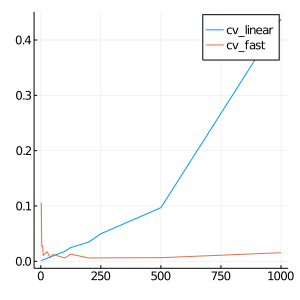

In [12]:
pp = plot(size=(300, 300))
plot!(pp, Ul, Vl, label="cv_linear")
plot!(pp, Uf, Vf, label="cv_fast")
pp

# 例43 ブートストラップ

In [19]:
function bt(df, f, r)
    m = size(df)[1]
    org = f(df, collect(1:m))
    u = Float64[]
    for j in 1:r
        index = StatsBase.sample(1:m, m, replace=true)
        push!(u, f(df, index))
    end
    Dict("original" => org, "bias" => mean(u) - org, "stderr" => std(u))
end

bt (generic function with 1 method)

In [20]:
function func_1(data, index)
    X = data[index, 1]
    Y = data[index, 2]
    (var(Y) - var(X)) / (var(X) + var(Y) - 2 * cov(X, Y))
end

func_1 (generic function with 1 method)

In [21]:
# Portfolio
Portfolio = readdlm("portfolio.csv", ',', skipstart=1);
bt(Portfolio, func_1, 1000)

Dict{String,Float64} with 3 entries:
  "original" => 0.151664
  "bias"     => 0.00477728
  "stderr"   => 0.174967

# 例44 ブートストラップの確認

In [22]:
df = readdlm("crime.txt", '\t')

50×7 Array{Float64,2}:
  478.0   184.0  40.0  74.0  11.0  31.0  20.0
  494.0   213.0  32.0  72.0  11.0  43.0  18.0
  643.0   347.0  57.0  70.0  18.0  16.0  16.0
  341.0   565.0  31.0  71.0  11.0  25.0  19.0
  773.0   327.0  67.0  72.0   9.0  29.0  24.0
  603.0   260.0  25.0  68.0   8.0  32.0  15.0
  484.0   325.0  34.0  68.0  12.0  24.0  14.0
  546.0   102.0  33.0  62.0  13.0  28.0  11.0
  424.0    38.0  36.0  69.0   7.0  25.0  12.0
  548.0   226.0  31.0  66.0   9.0  58.0  15.0
  506.0   137.0  35.0  60.0  13.0  21.0   9.0
  819.0   369.0  30.0  81.0   4.0  77.0  36.0
  541.0   109.0  44.0  66.0   9.0  37.0  12.0
    ⋮                               ⋮        
  989.0  1375.0  22.0  49.0   9.0  46.0  13.0
  821.0  1139.0  30.0  54.0  13.0  27.0  12.0
 1740.0  3545.0  86.0  62.0  22.0  18.0  15.0
  815.0   706.0  30.0  47.0  17.0  39.0  11.0
  760.0   451.0  32.0  45.0  34.0  15.0  10.0
  936.0   433.0  43.0  48.0  26.0  23.0  12.0
  863.0   601.0  20.0  69.0  23.0   7.0  12.0
  783.0  10

In [23]:
@sk_import linear_model: LinearRegression
reg = LinearRegression()
X = df[:, [3, 4]]
y = df[:, 1]
ScikitLearn.fit!(reg, X, y)
reg.coef_

2-element Array{Float64,1}:
 11.858330796711094
 -5.973411688164963

In [24]:
for j in [0, 1, 2]
    function func2(data, index)
        X = data[index, [3, 4]]
        y = data[index, 1]
        reg = LinearRegression()
        ScikitLearn.fit!(reg, X, y)
        if j == 0
            return reg.intercept_
        else
            return reg.coef_[j]
        end
    end
    println(bt(df, func2, 1000))
end

Dict("original" => 621.4260363802889,"bias" => 41.0723956734123,"stderr" => 216.72469148934323)
Dict("original" => 11.858330796711094,"bias" => -0.32861348070689544,"stderr" => 3.2340313546370116)
Dict("original" => -5.973411688164963,"bias" => -0.2489704889066333,"stderr" => 3.2633156993186265)
